# Multimodal Analysis of Single cell CITEseq data of Engineered AML cell lines

In [10]:
"""
Multimodal Analysis of Single-cell CITE-seq Data from Engineered AML Cell Lines

This script performs the following tasks:
1. Loads and preprocesses single-cell RNA-seq data
2. Conducts quality control and filtering
3. Performs normalization, feature selection, and scaling
4. Applies dimensionality reduction and clustering
5. Annotates cell types
6. Saves the processed data as an h5ad file
7. Benchmarks the performance of backed vs unbacked modes when reading the h5ad file

Author: Aymen Maqsood
Date: [Current 2024-07-22
"""

'\nMultimodal Analysis of Single-cell CITE-seq Data from Engineered AML Cell Lines\n\nThis script performs the following tasks:\n1. Loads and preprocesses single-cell RNA-seq data\n2. Conducts quality control and filtering\n3. Performs normalization, feature selection, and scaling\n4. Applies dimensionality reduction and clustering\n5. Annotates cell types\n6. Saves the processed data as an h5ad file\n7. Benchmarks the performance of backed vs unbacked modes when reading the h5ad file\n\nAuthor: Aymen Maqsood\nDate: [Current 2024-07-22\n'

## LOADING MODULES

In [11]:
# pip install scvelo 

In [12]:
# # Import required libraries
import numpy as np
import pandas as pd 
import scanpy as sc
import muon as mu
import os
from muon import prot as pt
import matplotlib
import matplotlib.pyplot as plt
import psutil
import time
import gc



In [13]:
pwd

'/Users/aymenmaqsoodmulbagal/Library/CloudStorage/OneDrive-VorBiopharma/Desktop/Projects/co-op/side_projects/matt_project'

In [14]:
# Loading the data 
## change path for data 
mdata = mu.read_10x_h5("/Users/aymenmaqsoodmulbagal/Library/CloudStorage/OneDrive-VorBiopharma/Desktop/Projects/co-op/side_projects/matt_project/filtered_feature_bc_matrix.h5")

/Users/aymenmaqsoodmulbagal/Library/CloudStorage/OneDrive-VorBiopharma/Desktop/Projects/co-op/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/aymenmaqsoodmulbagal/Library/CloudStorage/OneDrive-VorBiopharma/Desktop/Projects/co-op/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/aymenmaqsoodmulbagal/Library/CloudStorage/OneDrive-VorBiopharma/Desktop/Projects/co-op/.venv/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/pu

In [15]:
mdata

MuData object with n_obs × n_vars = 24717 × 36685
  2 modalities
    rna:	24717 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    prot:	24717 x 84
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [16]:
mdata.mod['rna'].obs_names

Index(['AAACCTGAGACCGGAT-1', 'AAACCTGAGCACCGTC-1', 'AAACCTGAGCGAGAAA-1',
       'AAACCTGCAACGATCT-1', 'AAACCTGGTAGCGTCC-1', 'AAACCTGGTCCGTGAC-1',
       'AAACCTGGTGTGAATA-1', 'AAACCTGGTGTGACCC-1', 'AAACCTGTCAGCGACC-1',
       'AAACCTGTCGTGGGAA-1',
       ...
       'TTTGTCAAGATGTGTA-4', 'TTTGTCACAACTGCGC-4', 'TTTGTCACACAGCCCA-4',
       'TTTGTCACACATCCGG-4', 'TTTGTCACACTAGTAC-4', 'TTTGTCACAGCCTGTG-4',
       'TTTGTCAGTAAGTGTA-4', 'TTTGTCAGTAGGAGTC-4', 'TTTGTCAGTTCCAACA-4',
       'TTTGTCATCCGTAGGC-4'],
      dtype='object', length=24717)

In [17]:
mdata.mod['rna'].var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [18]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 24717 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

## QC METRIC

In [19]:
rna.var['mt'] = rna.var_names.str.startswith('MT-') # Annotate the mitochondiral gene group 
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top = None, log1p = False, inplace = True)

In [20]:

## Removing duplicates
rna.var_names_make_unique()
## anndata object 
rna

AnnData object with n_obs × n_vars = 24717 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

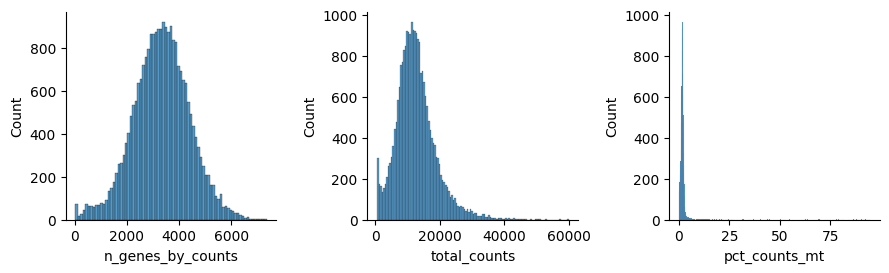

In [21]:
## PLOTTING THE QC METRICS
mu.pl.histogram(rna, ['n_genes_by_counts', 'total_counts','pct_counts_mt'])

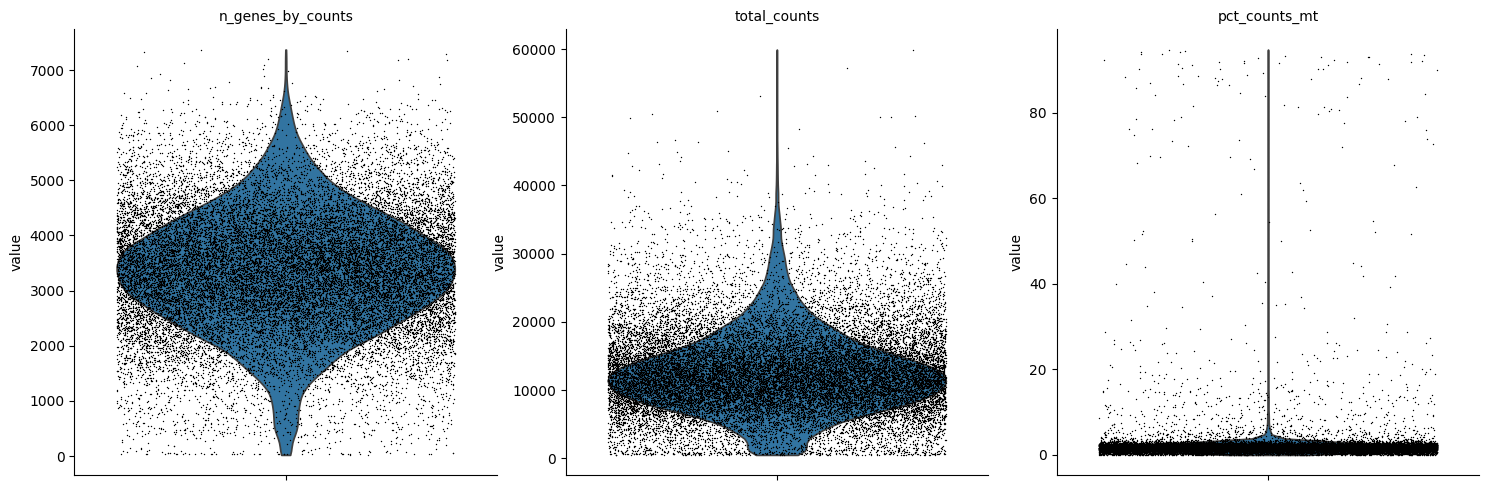

In [22]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts','pct_counts_mt'], jitter = 0.4, multi_panel = True)

### Filtering


In [23]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)  # inplace filtering 

In [24]:
rna

AnnData object with n_obs × n_vars = 24717 × 23616
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [25]:
rna.var

,gene_ids,feature_types,genome,pattern,read,sequence,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,,,,False,43,0.001740,99.826031,43.0
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,,,,False,3,0.000121,99.987863,3.0
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,,,,False,68,0.002751,99.724886,68.0
AP006222.2,ENSG00000286448,Gene Expression,GRCh38,,,,False,13,0.000526,99.947405,13.0
LINC01409,ENSG00000237491,Gene Expression,GRCh38,,,,False,1482,0.063802,94.004127,1577.0
...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,,,,False,169,0.006837,99.316260,169.0
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,,,,False,2614,0.116600,89.424283,2882.0
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,,,,False,56,0.002347,99.773435,58.0
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,,,,False,52,0.002104,99.789618,52.0


In [26]:
rna.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGACCGGAT-1,4401,16623.0,278.0,1.672382
AAACCTGAGCACCGTC-1,4099,15898.0,216.0,1.358661
AAACCTGAGCGAGAAA-1,4156,13418.0,266.0,1.982412
AAACCTGCAACGATCT-1,3773,11618.0,296.0,2.547771
AAACCTGGTAGCGTCC-1,3794,12900.0,299.0,2.317829
...,...,...,...,...
TTTGTCACAGCCTGTG-4,2516,6429.0,41.0,0.637735
TTTGTCAGTAAGTGTA-4,400,655.0,95.0,14.503818
TTTGTCAGTAGGAGTC-4,2737,10834.0,158.0,1.458372
TTTGTCAGTTCCAACA-4,3965,13848.0,497.0,3.588966


In [27]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# Same as the following but doesn't copy the object
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]

mu.pp.filter_obs(rna, 'total_counts', lambda x: (x > 1500) & (x < 15000))
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

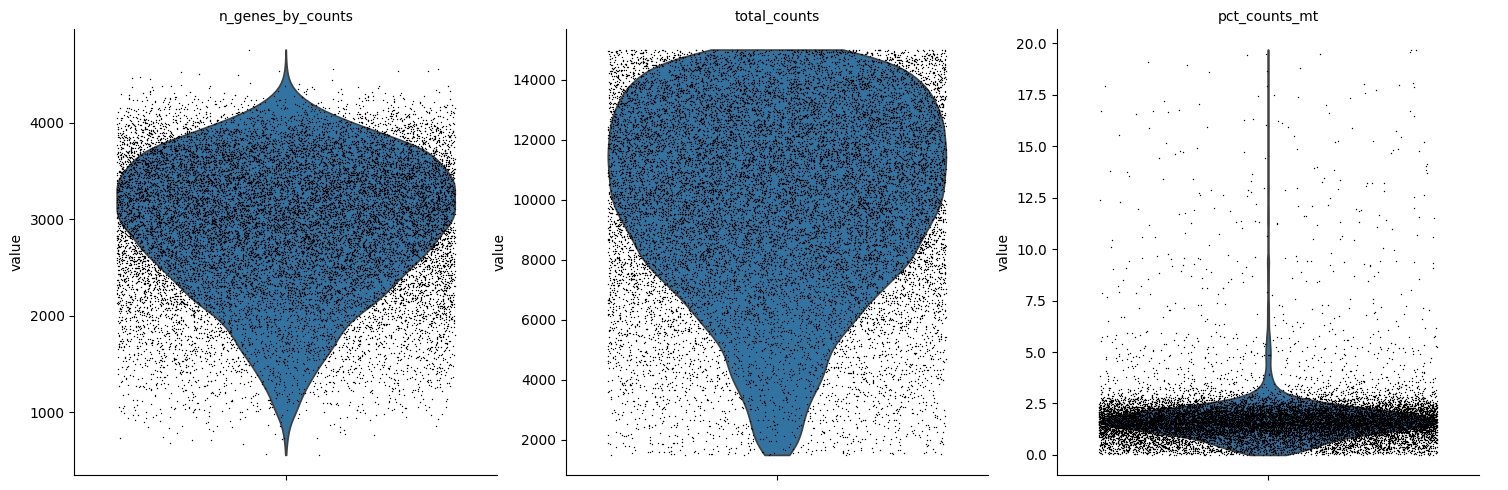

In [28]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

## NORMALIZATION




In [29]:

sc.pp.normalize_total(rna, target_sum = 1e4)

In [30]:
sc.pp.log1p(rna)

## Feature Selection 

In [31]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean = 4, min_disp = 0.5)

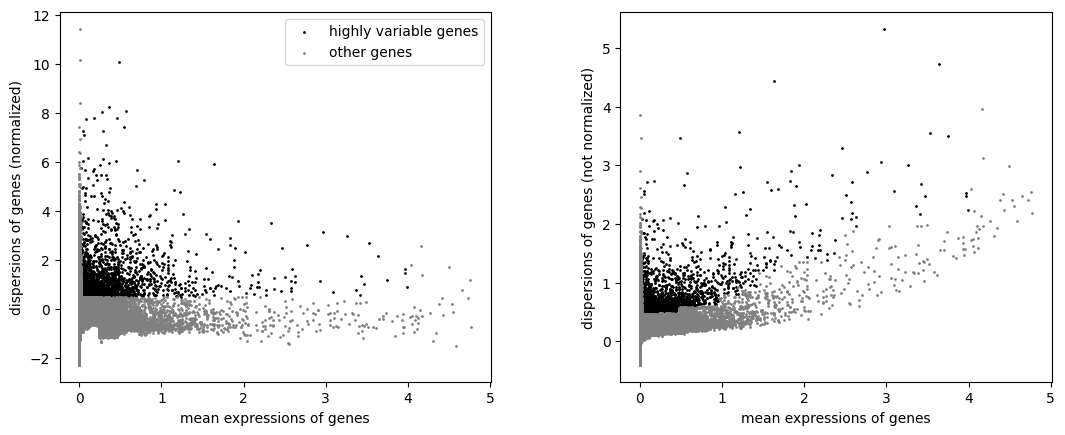

In [32]:
sc.pl.highly_variable_genes(rna)

### Scaling 

In [33]:
rna.raw = rna

In [34]:
## scaling the data 
sc.pp.scale(rna, max_value= 10)

## Analysis 

## PCA and Neighbourhood graph 

In [35]:
sc.tl.pca(rna, svd_solver = 'arpack')

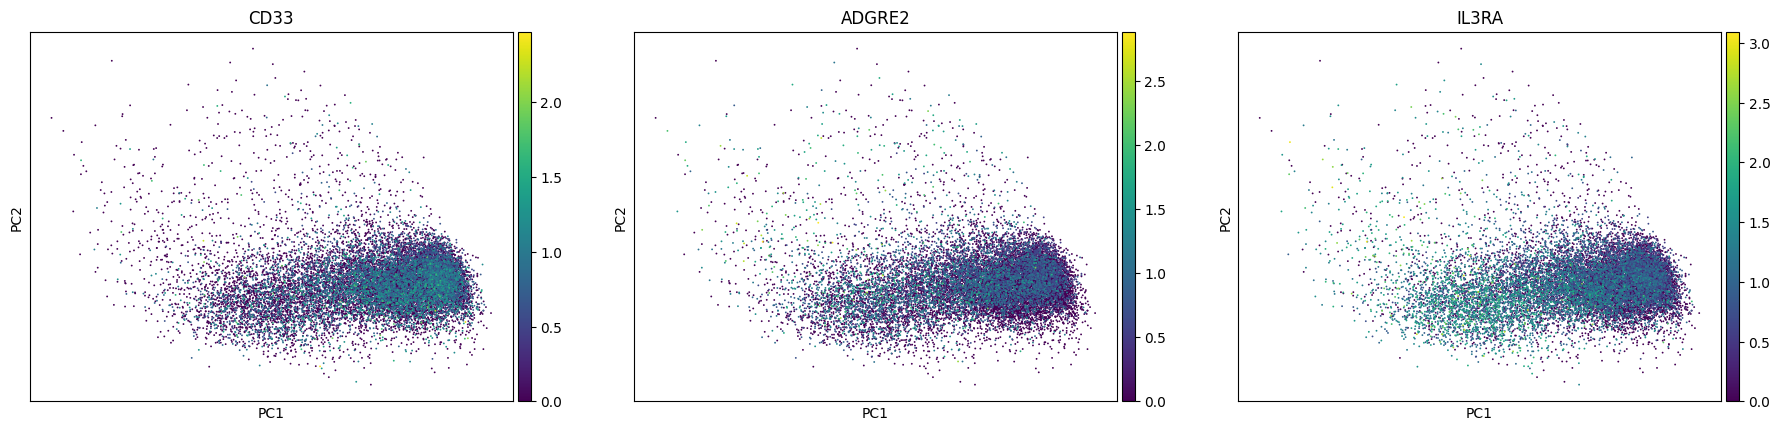

In [36]:
sc.pl.pca(rna , color = ['CD33', 'ADGRE2', 'IL3RA'])

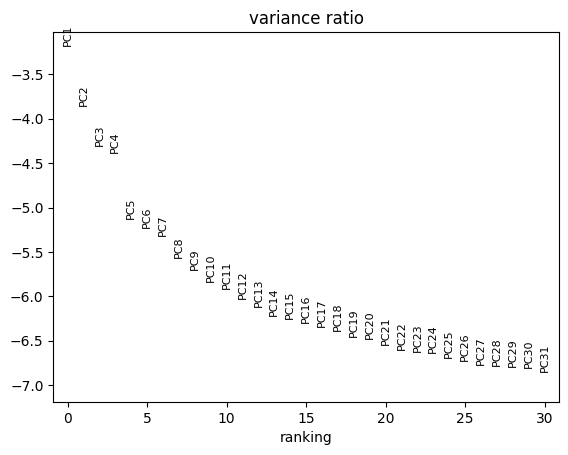

In [37]:
## Neighbourbood Graph
sc.pl.pca_variance_ratio(rna, log=True)

In [38]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

## Dimensionality Reduction and clustering


In [39]:
sc.tl.leiden(rna, resolution = .75)

ImportError: Please install the igraph package: `conda install -c conda-forge python-igraph` or `pip3 install igraph`.

In [ ]:
sc.tl.umap(rna, spread = 1, min_dist = 0.5, random_state = 11)

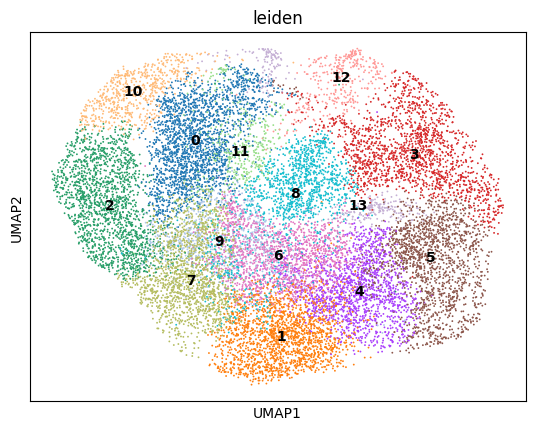

In [ ]:
sc.pl.umap(rna, color = 'leiden' , legend_loc = "on data")

### Cell type annoation 

In [ ]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test_overestim_var')

In [ ]:
# Differential expressed 
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p
0,HIST1H1B,0.0,CST3,1.892869e-185,CDC20,0.000000e+00,NDRG1,0.000000e+00,ENPP2,4.727081e-198,FTH1,0.000000e+00,PDE7A,1.207748e-89,RPS26,3.513279e-205,PRG2,0.000000e+00,MCM3,1.785289e-120,UBE2C,0.000000e+00,PRG2,2.202518e-196,MT-CO1,1.262211e-102,DDIT4,1.962051e-98
1,RRM2,0.0,RPL28,1.766817e-143,HMGB2,0.000000e+00,GBE1,0.000000e+00,SLC44A1,2.366675e-136,PNRC1,3.621068e-286,CTSG,5.391190e-83,FABP5,1.496080e-176,ELANE,6.967414e-196,NME1,4.780611e-111,TOP2A,1.915016e-276,HIST1H4C,8.534836e-116,MT-ND1,1.889082e-94,VEGFA,3.924590e-84
2,HIST1H4C,0.0,RPS12,3.533001e-135,PTTG1,0.000000e+00,MALAT1,3.695611e-321,CD74,2.983909e-134,LSP1,1.573963e-284,PRTN3,1.574359e-70,POLR2L,1.799967e-156,PRSS57,1.100791e-190,RANBP1,4.725384e-109,UBE2S,3.044503e-252,RHEX,1.976535e-79,MTRNR2L12,9.340105e-94,EIF1,6.545105e-78
3,TYMS,0.0,RPS28,4.760313e-129,CCNB1,0.000000e+00,GPI,1.215073e-310,FLT3,9.156206e-128,TRPM4,4.715142e-273,PRKDC,5.410487e-63,ATP5MF,3.164121e-154,AZU1,6.462044e-151,SNRPB,5.377151e-100,CENPF,3.521969e-245,CALR,5.250739e-77,DACH1,1.085737e-90,CAMTA2,1.387908e-63
4,DUT,0.0,RPS13,1.141308e-125,CDKN3,0.000000e+00,BNIP3,4.628449e-310,CNTN4,8.020115e-115,MALAT1,3.829815e-261,ELANE,4.912331e-61,HSPE1,6.815368e-150,PRTN3,4.627001e-127,SRM,2.674782e-100,TUBA1C,1.160566e-228,RRM2,1.004502e-65,MT-ND6,6.249005e-87,CDC42EP3,4.080800e-65
5,TUBB,0.0,LYZ,4.564921e-128,UBE2S,0.000000e+00,YPEL3,1.502795e-298,LSP1,6.549416e-103,ACTG1,5.784454e-246,AFF3,6.468356e-61,SNRPG,8.621005e-150,APLP2,5.137851e-128,RAN,4.753813e-96,MKI67,3.101706e-231,ATAD2,6.401614e-63,MT-CO2,8.423537e-88,TRIB3,3.321599e-56
6,ATAD2,0.0,RPS8,2.158563e-122,HMGN2,6.238876e-302,ALDOA,1.072976e-294,LY86,1.282889e-96,TYROBP,9.709899e-238,YBX1,7.211649e-60,COX6C,4.814234e-141,RHEX,1.908889e-120,GINS2,1.513705e-99,PLK1,4.077880e-209,DUT,3.324795e-61,MT-ATP6,1.286939e-86,ASS1,3.584516e-59
7,PCNA,0.0,RPS19,5.100450e-120,TUBA1B,1.746245e-284,PNRC1,7.990728e-299,CISH,1.323525e-93,BNIP3L,9.743466e-238,CAT,6.388200e-58,ATP5MC1,1.330475e-139,APOC2,1.662784e-122,MCM4,4.245765e-95,TUBB4B,6.613214e-210,HMGB1,5.768560e-57,MT-ND3,2.569597e-82,BNIP3,8.236476e-59
8,STMN1,0.0,RPL12,3.968662e-119,RAD21,1.713080e-295,MYLIP,8.672280e-292,EEF2,6.338206e-89,VIM,4.533918e-236,HNRNPA2B1,5.983646e-54,UQCRQ,4.615091e-139,RPL37A,2.229554e-105,PFN1,1.981343e-89,HMGB2,8.401637e-187,TYMS,8.514709e-60,CCDC26,1.703300e-82,PHGDH,1.595716e-56
9,H2AFZ,0.0,RPLP2,4.826834e-102,BIRC5,1.091806e-295,APOC1,7.984225e-256,EEF1A1,2.064363e-78,ALDOA,1.997814e-218,MT1G,2.238406e-53,NDUFS5,8.761917e-137,RPS27,2.195268e-96,FABP5,1.272918e-89,TPX2,1.196211e-213,PRSS57,3.387964e-57,DLEU2,3.261072e-82,AARS,5.890246e-51


In [ ]:
# Define new cluster names based on marker genes
new_cluster_names = {
    "0": "Histone H1B+", "1": "CST3+", "2": "CDC20+", "3": "NDRG1+",
    "4": "ENPP2+", "5": "FTH1+", "6": "PDE7A+", "7": "RPS26+", 
    "8": "PRG2+", "9": "MCM3+", "10": "UBE2C+", "11": "MT-CO1+", 
    "12": "DDIT4+", "13": "VEGFA+"
}

rna.obs['celltype'] = rna.obs.leiden.astype("str").values
rna.obs.celltype = rna.obs.celltype.replace(new_cluster_names)
rna.obs.celltype = rna.obs.celltype.astype("category")


In [ ]:
# Functionality:
# This code snippet assigns new cluster names to cells based on marker gene expressions. 
# It replaces the default Leiden cluster labels with more meaningful biological labels 
# derived from marker genes and stores the updated cell type information in the `celltype` column.

# Step-by-step:
# 1. Define a dictionary (`new_cluster_names`) mapping Leiden cluster labels (as strings) to meaningful names.
# 2. Convert the Leiden cluster information to string format and store it in a new column, `celltype`, in the AnnData object's `obs` attribute.
# 3. Replace the Leiden cluster labels with the corresponding biological labels using the dictionary.
# 4. Convert the `celltype` column to a categorical data type for efficient storage and downstream analysis.

# Define the new cluster names based on marker genes
new_cluster_names = {
    "0": "Histone H1B+",  # Cluster 0: Marked by Histone H1B expression
    "1": "CST3+",         # Cluster 1: Marked by CST3 expression
    "2": "CDC20+",        # Cluster 2: Marked by CDC20 expression
    "3": "NDRG1+",        # Cluster 3: Marked by NDRG1 expression
    "4": "ENPP2+",        # Cluster 4: Marked by ENPP2 expression
    "5": "FTH1+",         # Cluster 5: Marked by FTH1 expression
    "6": "PDE7A+",        # Cluster 6: Marked by PDE7A expression
    "7": "RPS26+",        # Cluster 7: Marked by RPS26 expression
    "8": "PRG2+",         # Cluster 8: Marked by PRG2 expression
    "9": "MCM3+",         # Cluster 9: Marked by MCM3 expression
    "10": "UBE2C+",       # Cluster 10: Marked by UBE2C expression
    "11": "MT-CO1+",      # Cluster 11: Marked by MT-CO1 expression
    "12": "DDIT4+",       # Cluster 12: Marked by DDIT4 expression
    "13": "VEGFA+"        # Cluster 13: Marked by VEGFA expression
}

# Assign cell type information based on Leiden clusters
# Step 1: Convert Leiden cluster labels to string format and assign to `celltype`
rna.obs['celltype'] = rna.obs.leiden.astype("str").values

# Step 2: Replace the Leiden cluster labels with the meaningful names from the dictionary
rna.obs['celltype'] = rna.obs['celltype'].replace(new_cluster_names)

# Step 3: Convert the `celltype` column to a categorical data type for optimized storage
rna.obs['celltype'] = rna.obs['celltype'].astype("category")

# Note:
# - The Leiden clustering is a method used in scRNA-seq data analysis for grouping cells into clusters.
# - Replacing default cluster labels with biologically meaningful names enhances interpretability.
# - Using categorical data for `celltype` reduces memory usage and ensures efficient operations in downstream analyses.


In [ ]:
# Re-order categories based on the new cluster names
rna.obs.celltype = rna.obs.celltype.cat.reorder_categories([
    'Histone H1B+', 'CST3+', 'CDC20+', 'NDRG1+', 'ENPP2+', 'FTH1+',
    'PDE7A+', 'RPS26+', 'PRG2+', 'MCM3+', 'UBE2C+', 'MT-CO1+',
    'DDIT4+', 'VEGFA+'], ordered=True)

mdata.update()


/Users/aymenmaqsoodmulbagal/Library/CloudStorage/OneDrive-VorBiopharma/Desktop/Projects/co-op/matt_project/.venv/lib/python3.12/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


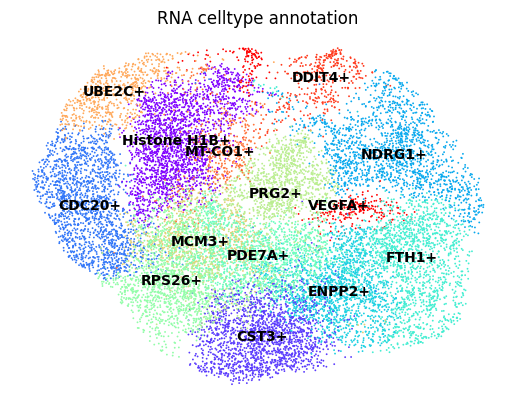

In [ ]:
# Take colors from a palette
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))

rna.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))
sc.pl.umap(rna, color="celltype", legend_loc="on data", frameon=False, title="RNA celltype annotation")


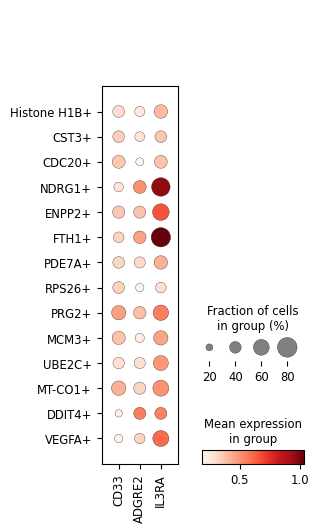

In [ ]:
# Define marker genes for plotting
marker_genes = ['CD33', 'ADGRE2', 'IL3RA']
sc.pl.dotplot(rna, marker_genes, groupby='celltype')

In [ ]:
### Further analysis

## SAVING AnnData as h5ad file for bench marking 
rna.write_h5ad("/Users/aymenmaqsoodmulbagal/Library/CloudStorage/OneDrive-VorBiopharma/Desktop/Projects/co-op/matt_project/rna_data.h5ad")

print("AnnData object saved successfully.")

AnnData object saved successfully.


In [ ]:
# Benchmarking section
print("\n--- Benchmarking Backed vs Unbacked Modes ---")

# File path
h5ad_file = "/Users/aymenmaqsoodmulbagal/Library/CloudStorage/OneDrive-VorBiopharma/Desktop/Projects/co-op/matt_project/rna_data.h5ad"

# Get initial memory usage
process = psutil.Process(os.getpid())
initial_memory = process.memory_info().rss / 1024 / 1024  # Convert to MB

print("Initial memory usage: {:.2f} MB".format(initial_memory))


Initial memory usage: 450.13 MB


In [ ]:

# Benchmark unbacked mode
start_time = time.time()
adata_unbacked = sc.read_h5ad(h5ad_file)
end_time = time.time()

current_memory = process.memory_info().rss / 1024 / 1024
memory_used_unbacked = current_memory - initial_memory

print("\nUnbacked mode:")
print("Time taken: {:.2f} seconds".format(end_time - start_time))
print("Additional memory used: {:.2f} MB".format(memory_used_unbacked))
print("Total memory usage: {:.2f} MB".format(current_memory))




Unbacked mode:
Time taken: 1.78 seconds
Additional memory used: 1986.82 MB
Total memory usage: 2436.95 MB


In [ ]:
# Clear memory
del adata_unbacked
gc.collect()

# Get memory usage after clearing
clear_memory = process.memory_info().rss / 1024 / 1024
print("\nMemory after clearing: {:.2f} MB".format(clear_memory))



Memory after clearing: 483.13 MB


In [ ]:

# Benchmark backed mode
start_time = time.time()
adata_backed = sc.read_h5ad(h5ad_file, backed='r')
end_time = time.time()

current_memory = process.memory_info().rss / 1024 / 1024
memory_used_backed = current_memory - clear_memory

print("\nBacked mode:")
print("Time taken: {:.2f} seconds".format(end_time - start_time))
print("Additional memory used: {:.2f} MB".format(memory_used_backed))
print("Total memory usage: {:.2f} MB".format(current_memory))

# Comparison
print("\nComparison:")
print("Memory difference (Unbacked - Backed): {:.2f} MB".format(memory_used_unbacked - memory_used_backed))


Backed mode:
Time taken: 0.44 seconds
Additional memory used: 18.79 MB
Total memory usage: 501.92 MB

Comparison:
Memory difference (Unbacked - Backed): 1968.03 MB


In [1]:
my_notebook = "Multimodal_Analysis.ipynb"
!jupyter nbconvert $my_notebook --to html


[NbConvertApp] Converting notebook Multimodal_Analysis.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 2385955 bytes to Multimodal_Analysis.html
